# Momentum Analysis
We have data:
    - Processed every play that has NGS Data available.
    - Every pair of players within 1 yard of eachother.
    - At least one of the players needs to have 100 kg m/s - Otherwise dropped
    - Calculated the opposing momentums (using the direction of momentum - of the two players
    - Each play is in it's own file (csv and parquet versions both saved)
    - Momentum is calculated assuming all players weigh the average of 245 pounds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import glob
import sys
sys.path.insert(0, '../scripts/')
from football_field import create_football_field
from plots import plot_play

%matplotlib inline
pd.options.display.max_columns = 100

%load_ext autoreload
%autoreload 2

## Test reading one play '2016-10-1275'

In [2]:
# Read the play
play = pd.read_parquet('../working/playlevel/momentum/min1yard/2016-10-1275-lessthan1y.parquet').drop('index', axis=1)

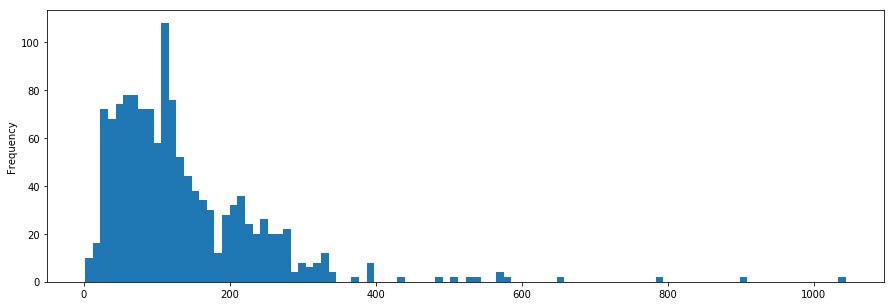

In [3]:
# Plot the opposing momentum values
play['opp_momentum'].plot(kind='hist', figsize=(15, 5), bins=100)

## Lets look at the really high opposing momentum moment

In [4]:
play.loc[play['opp_momentum'] == play['opp_momentum'].max()][['time','role','role_partner',
                                                              'punting_returning_team','punting_returning_team_partner']]

,time,role,role_partner,punting_returning_team,punting_returning_team_partner
828,2016-08-13 00:42:22.800,PR,PRG,Returning_Team,Punting_Team
829,2016-08-13 00:42:22.800,PRG,PR,Punting_Team,Returning_Team


## Plot this moment

In [17]:
high_momentum_time = play.sort_values('opp_momentum', ascending=False).time.values[0]

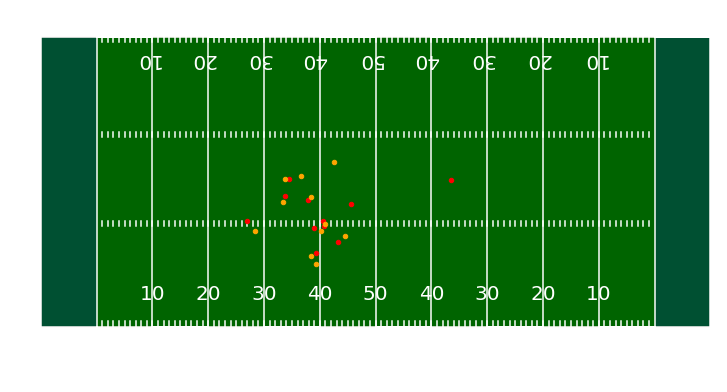

In [37]:
fig, ax = create_football_field()
play_all = pd.read_csv('../working/playlevel/during_play/2016-10-1275.csv')
play_all['time'] = pd.to_datetime(play_all['time'])
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Punting_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='red')
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Returning_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='orange')

## Plot all values
- This makes sense because the moment of high opposing momentum

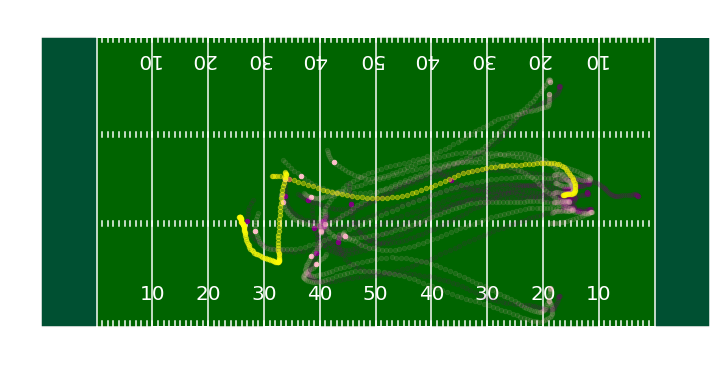

In [49]:
fig, ax = create_football_field()
play_all = pd.read_csv('../working/playlevel/during_play/2016-10-1275.csv')
play_all['time'] = pd.to_datetime(play_all['time'])
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Punting_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='purple')
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Returning_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='pink')
play_all.loc[(play_all['punting_returning_team'] == 'Punting_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='purple', alpha=0.1)
play_all.loc[(play_all['punting_returning_team'] == 'Returning_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='pink', alpha=0.1)
play_all.loc[play_all['role'].isin(['PR','PRG'])] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='yellow', alpha=0.4)

In [50]:
pi = pd.read_csv('../input/play_information.csv')

In [58]:
pi.loc[(pi['Season_Year'] == 2016) &
       (pi['GameKey'] == 10) &
       (pi['PlayID'] == 1275)]['PlayDescription'].values[0]

'(14:04) M.Darr punts 50 yards to NYG 32, Center-J.Denney. B.Rainey to NYG 33 for 1 yard (M.Hull, J.Lucas). PENALTY on NYG-L.McFadden, Offensive Holding, 10 yards, enforced at NYG 33.'

In [59]:
pi.loc[(pi['Season_Year'] == 2016) &
       (pi['GameKey'] == 10) &
       (pi['PlayID'] == 1275)]

,Season_Year,Season_Type,GameKey,Game_Date,Week,PlayID,Game_Clock,YardLine,Quarter,Play_Type,Poss_Team,Home_Team_Visit_Team,Score_Home_Visiting,PlayDescription
100,2016,Pre,10,08/12/2016,2,1275,14:04,MIA 18,2,Punt,MIA,NYG-MIA,10 - 0,"(14:04) M.Darr punts 50 yards to NYG 32, Cente..."


# Can we load all the play information at once????

In [6]:
%%time
if False == True:
    path = '../working/playlevel/momentum/min1yard'
    all_files = glob.glob(os.path.join(path, "*.parquet"))

    df = pd.concat((pd.read_parquet(f).drop('index', axis=1) for f in all_files))
    
    df.to_parquet('../working/momentum-allplays-1yarddistance.paruqet')
else:
    df = pd.read_parquet('../working/momentum-allplays-1yarddistance.paruqet')

CPU times: user 5.12 s, sys: 8.39 s, total: 13.5 s
Wall time: 1min 9s


## Plot all the play info

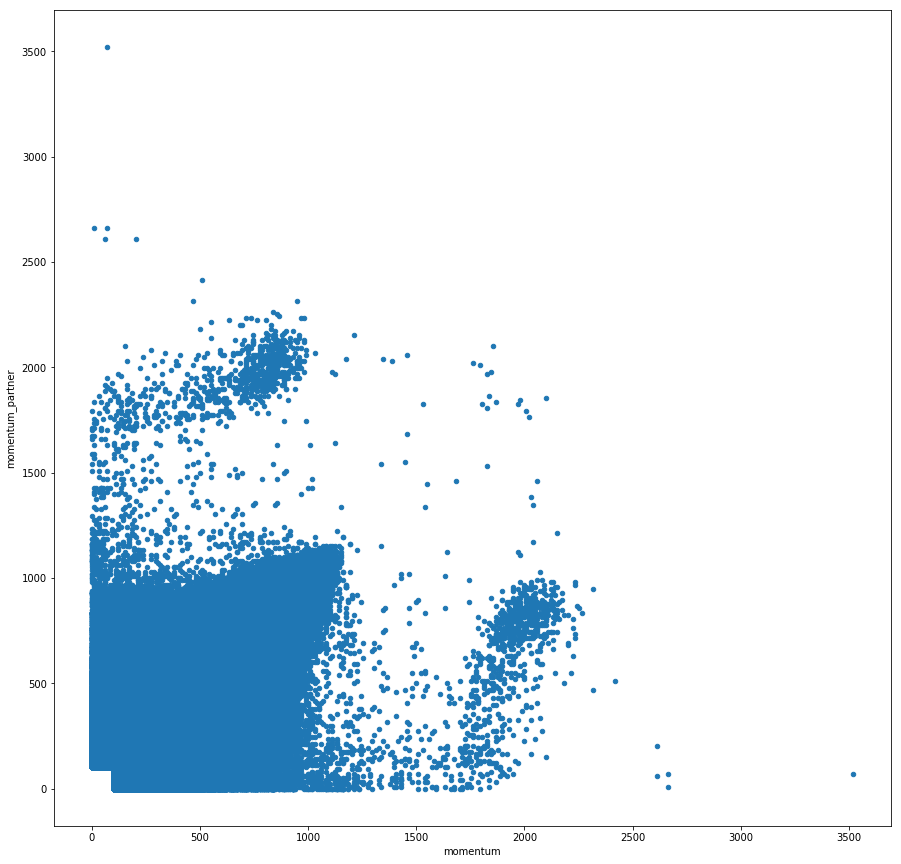

In [11]:
df.plot(x='momentum', y='momentum_partner', kind='scatter', figsize=(15, 15), title='Momentum of Player 1 and Player 2')

## Data Scrubbing - Remove unreasonibly high velocity
10 meters per second is about the limit of a human being speed

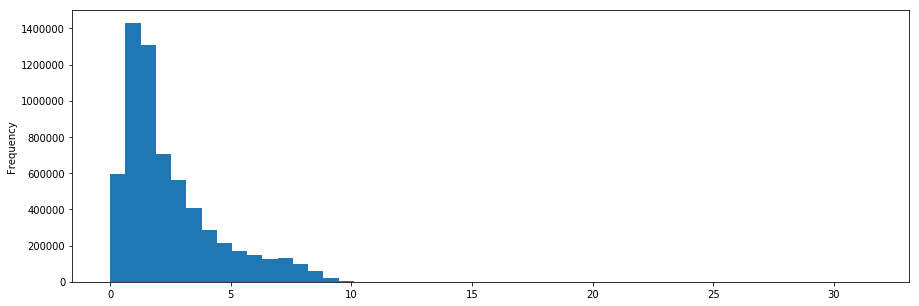

In [72]:
df['v_mps'].plot(kind='hist', bins=50, figsize=(15, 5))

### 10.2 meters per second is the fastest speed of human in 100 meter dash. 
- In spurts players could run fater, but 30meters per second is clearly dirty data - so lets cut off above 13 m/s

# Plot with Punting Team on one axis and Returning Team on Y axis

In [16]:
df_punting_vs_returning = df.loc[(df['punting_returning_team'] == 'Punting_Team') &
       (df['punting_returning_team_partner'] == 'Returning_Team')]

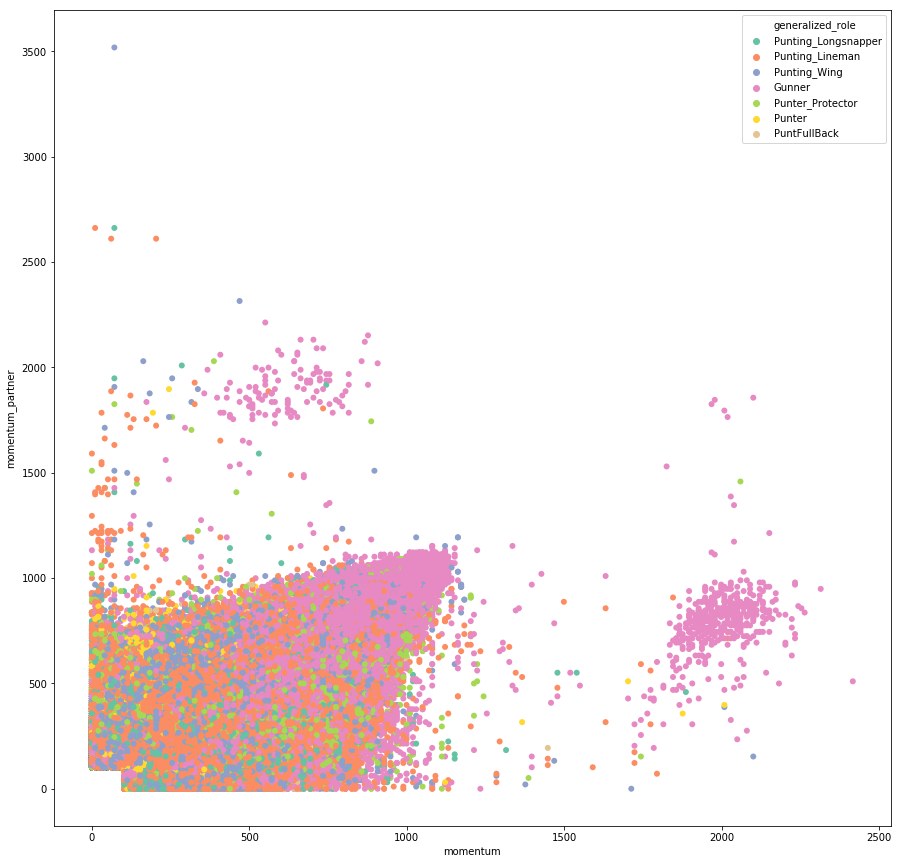

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.scatterplot(x='momentum',
                y='momentum_partner',
                hue='generalized_role',
                data=df_punting_vs_returning,
                palette='Set2',
                linewidth=0,
                ax=ax)

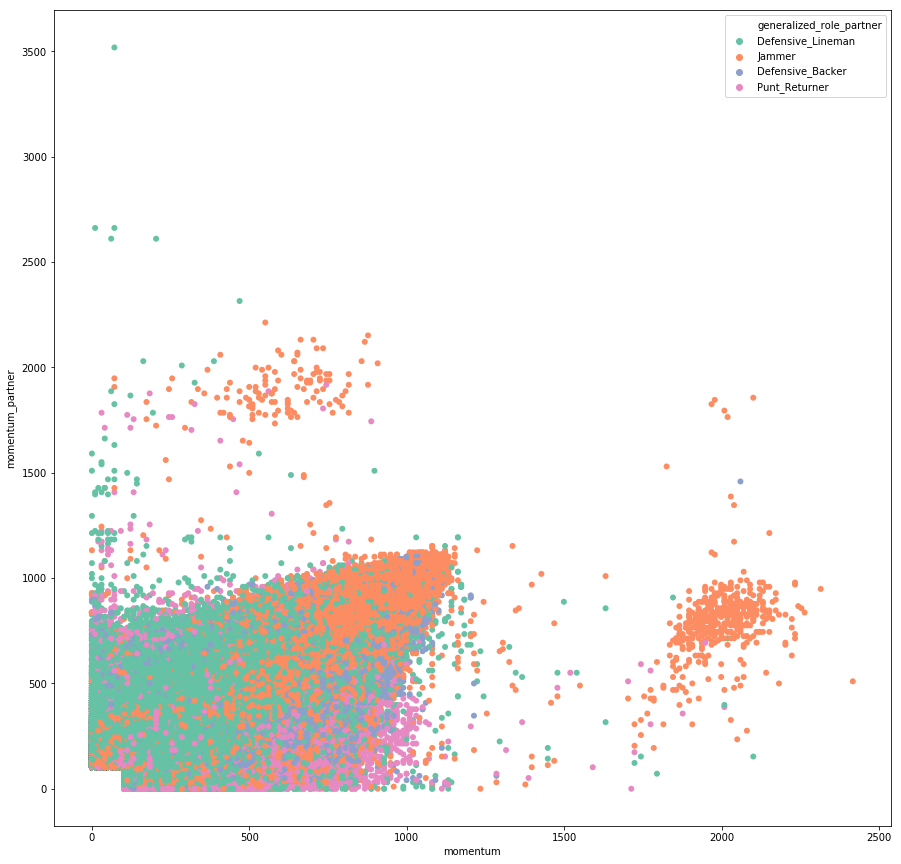

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.scatterplot(x='momentum',
                y='momentum_partner',
                hue='generalized_role_partner',
                data=df_punting_vs_returning,
                palette='Set2',
                linewidth=0,
                ax=ax)

# Color by opposing momentum

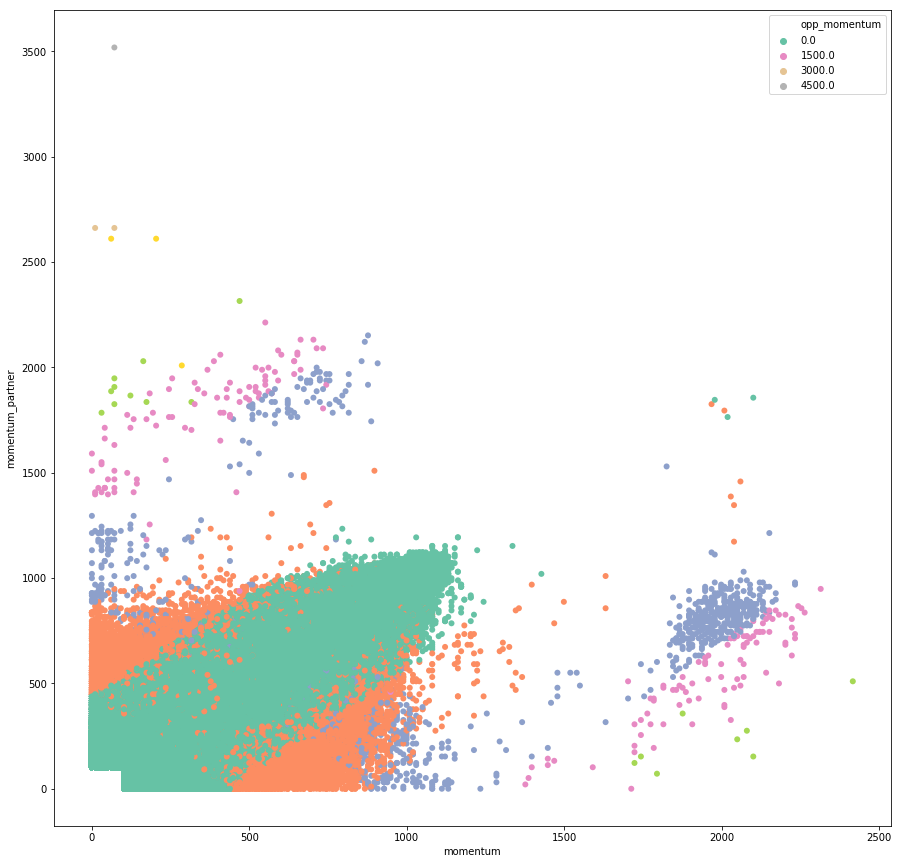

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.scatterplot(x='momentum',
                y='momentum_partner',
                hue='opp_momentum',
                data=df_punting_vs_returning,
                palette='Set2',
                linewidth=0,
                ax=ax)

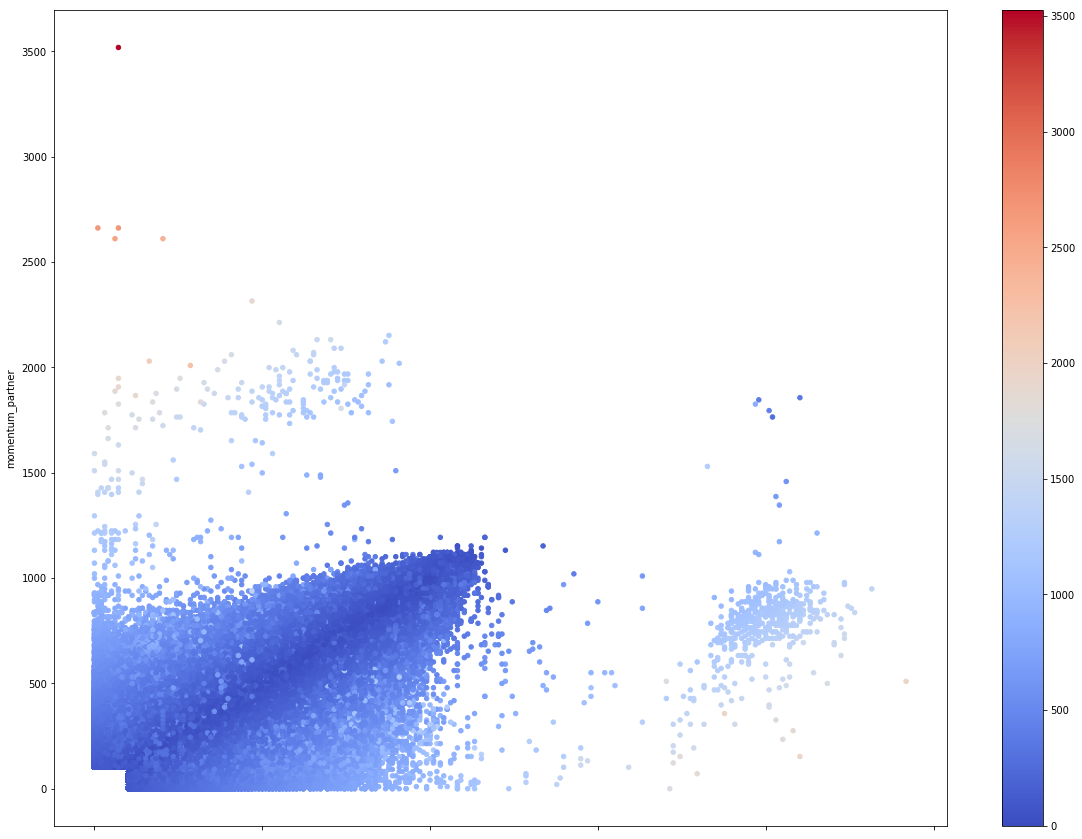

In [42]:
df_punting_vs_returning.plot(x='momentum',
                                        y='momentum_partner',
                                        kind='scatter',
                                        c=df_punting_vs_returning['opp_momentum'].tolist(),
                                        cmap='coolwarm',
                                      figsize=(20, 15))

In [45]:
# Unreasonibly high momentum values
df_punting_vs_returning.sort_values('opp_momentum', ascending=False).head()

,time,gsisid,x,y,o,dir,dis,role,mph,generalized_role,punting_returning_team,dis_meters,v_mps,dir_radians,o_radians,momentum,momentum_x,momentum_y,gsisid_partner,x_partner,y_partner,o_partner,dir_partner,dis_partner,role_partner,mph_partner,generalized_role_partner,punting_returning_team_partner,dis_meters_partner,v_mps_partner,dir_radians_partner,o_radians_partner,momentum_partner,momentum_x_partner,momentum_y_partner,distance_to_partner,opp_momentum,Season_Year,GameKey,PlayID
361,2016-12-04 20:35:57.300,31057.0,54.630001,32.880001,26.010000,161.919998,0.07,PLW,1.431818,Punting_Wing,Punting_Team,0.064009,0.640088,2.826037,0.453960,71.382731,-67.858145,22.153248,28836.0,53.830002,32.500000,57.310001,256.600006,3.45,PDR3,70.568183,Defensive_Lineman,Returning_Team,3.154718,31.547184,4.478515,1.000248,3518.148908,-815.323269,-3422.370481,0.885663,3524.691169,2016,246,3522
132,2016-11-20 23:40:08.600,23173.0,16.020000,23.480000,345.420013,48.529999,0.07,PLS,1.431818,Punting_Longsnapper,Punting_Team,0.064009,0.640088,0.847008,6.028717,71.382731,47.271630,53.487262,32248.0,15.170000,23.270000,124.650002,303.290009,2.61,PDL3,53.386362,Defensive_Lineman,Returning_Team,2.386613,23.866129,5.293409,2.175553,2661.555987,1460.867021,-2224.802872,0.875557,2681.204555,2016,222,3057
133,2016-11-20 23:40:08.600,31719.0,15.430000,22.730000,132.119995,185.020004,0.01,PRG,0.204545,Punting_Lineman,Punting_Team,0.009144,0.091441,3.229208,2.305929,10.197533,-10.158417,-0.892320,32248.0,15.170000,23.270000,124.650002,303.290009,2.61,PDL3,53.386362,Defensive_Lineman,Returning_Team,2.386613,23.866129,5.293409,2.175553,2661.555987,1460.867021,-2224.802872,0.599334,2666.400941,2016,222,3057
126,2016-12-04 18:14:24.100,31130.0,55.639999,22.490000,205.429993,71.389999,0.06,PLG,1.227273,Punting_Lineman,Punting_Team,0.054865,0.548647,1.245991,3.585430,61.185196,19.525709,57.985989,28836.0,55.889999,21.889999,26.840000,82.959999,2.56,PDR3,52.363635,Defensive_Lineman,Returning_Team,2.340892,23.408924,1.447925,0.468446,2610.568371,319.957153,2590.886844,0.650000,2550.655954,2016,246,391
127,2016-12-04 18:14:24.100,31902.0,55.680000,21.150000,195.339996,92.269997,0.20,PLT,4.090909,Punting_Lineman,Punting_Team,0.182882,1.828822,1.610415,3.409326,203.950662,-8.078190,203.790616,28836.0,55.889999,21.889999,26.840000,82.959999,2.56,PDR3,52.363635,Defensive_Lineman,Returning_Team,2.340892,23.408924,1.447925,0.468446,2610.568371,319.957153,2590.886844,0.769220,2409.530159,2016,246,391


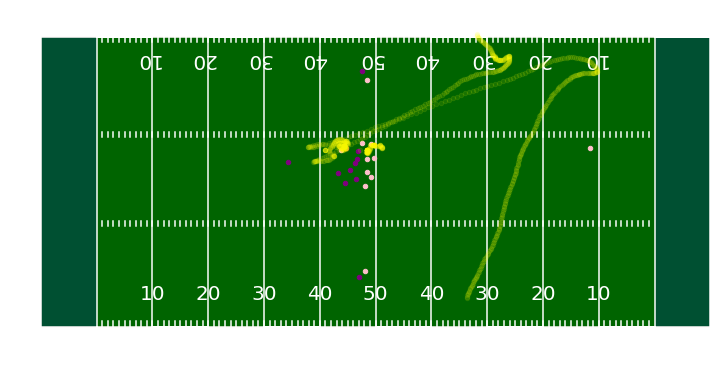

In [57]:
play_all = pd.read_csv('../working/playlevel/all_data/2016-246-3522.csv')
fig, ax = create_football_field()
play_all['time'] = pd.to_datetime(play_all['time'])
high_momentum_time = pd.to_datetime('2016-12-04 20:35:57.300')
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Punting_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='purple')
play_all.loc[(play_all['time'] == high_momentum_time) &
             (play_all['punting_returning_team'] == 'Returning_Team')] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='pink')
# play_all.loc[(play_all['punting_returning_team'] == 'Punting_Team')] \
#     .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='purple', alpha=0.05)
# play_all.loc[(play_all['punting_returning_team'] == 'Returning_Team')] \
#     .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='pink', alpha=0.05)
play_all.loc[play_all['role'].isin(['PLW','PDR3'])] \
    .plot(x='x',y='y',kind='scatter', ax=ax, zorder=4, color='yellow', alpha=0.1)

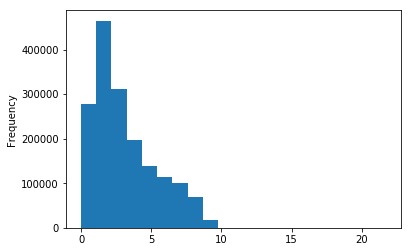

In [65]:
df_punting_vs_returning['v_mps'].plot(kind='hist', bins=20)

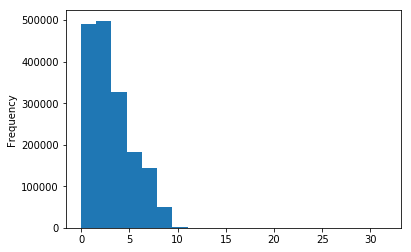

In [67]:
df_punting_vs_returning['v_mps'].max()

21.671542479508798

In [68]:
df_punting_vs_returning['v_mps_partner'].max()

31.547184049777947

In [52]:
pi = pd.read_csv('../input/play_information.csv')
pi.loc[(pi['Season_Year'] == 2016) &
       (pi['GameKey'] == 246) &
       (pi['PlayID'] == 3522)].values

array([[2016, 'Reg', 246, '12/04/2016', 13, 3522, '08:14', 'CHI 48', 4,
        'Punt', 'CHI', 'CHI-SF', '24 - 6',
        "(8:14) (Punt formation) P.O'Donnell punts 52 yards to end zone, Center-P.Scales, Touchback. PENALTY on SF-R.Robinson, Offensive Holding, 10 yards, enforced at SF 20."]],
      dtype=object)